# 네이버 검색어 트렌드 복수 단어

## #01. 작업 준비

### 패키지 참조

In [1]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

### 그래프 한글 설정

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 네이버 검색어 트렌드 OpenAPI 연동

### 접속에 필요한 정보 설정

#### API URL

In [3]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

#### 발급받은 인증키

In [4]:
client_id = "ZpgN4whrqEh7K4rhkGjN"
client_secret = "aQwN4h5rFG"

### 접속 객체 생성

In [5]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 전달할 검색어 구성

In [6]:
data = {
    "startDate": "2022-07-01",
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "반다이",  # 검색주제
            "keywords": ["뉴건담", "하이뉴", "제타", "사자비"]   # 주제와 관련된 검색어
        },
        {
            "groupName": "굿스마일",  # 검색주제
            "keywords": ["그랑죠", "더합체", "모데로이드", "다간"]   # 주제와 관련된 검색어
        },
        {
            "groupName": "플레이스테이션5",  # 검색주제
            "keywords": ["파이널판타지", "갓오브워", "호라이즌", "데스스트렌딩"]   # 주제와 관련된 검색어
        }
    ]
}

### 데이터 요청하기

In [7]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2022-07-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': '반다이',
   'keywords': ['뉴건담', '하이뉴', '제타', '사자비'],
   'data': [{'period': '2022-07-01', 'ratio': 9.96173},
    {'period': '2022-07-02', 'ratio': 10.2009},
    {'period': '2022-07-03', 'ratio': 9.53121},
    {'period': '2022-07-04', 'ratio': 14.02774},
    {'period': '2022-07-05', 'ratio': 11.1337},
    {'period': '2022-07-06', 'ratio': 8.83759},
    {'period': '2022-07-07', 'ratio': 18.29705},
    {'period': '2022-07-08', 'ratio': 12.37742},
    {'period': '2022-07-09', 'ratio': 16.46735},
    {'period': '2022-07-10', 'ratio': 27.38579},
    {'period': '2022-07-11', 'ratio': 23.11647},
    {'period': '2022-07-12', 'ratio': 24.3004},
    {'period': '2022-07-13', 'ratio': 14.30279},
    {'period': '2022-07-14', 'ratio': 13.04711},
    {'period': '2022-07-15', 'ratio': 13.45371},
    {'period': '2022-07-16', 'ratio': 12.58072},
    {'period': '2022-07-17', 'ratio': 13.38196},
    {'period': '

### 응답 결과 구조

In [8]:
print("검색 결과 수 :", len(mydict['results']))

검색 결과 수 : 3


In [9]:
title1 = mydict['results'][0]['title']
print(title1)

data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={'ratio':title1}, inplace=True)
df1.head()

반다이


,period,반다이
0,2022-07-01,9.96173
1,2022-07-02,10.20090
2,2022-07-03,9.53121
3,2022-07-04,14.02774
4,2022-07-05,11.13370


In [10]:
title2 = mydict['results'][1]['title']
print(title2)

data = mydict['results'][1]['data']
df2 = DataFrame(data)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()

굿스마일


,period,굿스마일
0,2022-07-01,5.16622
1,2022-07-02,6.40994
2,2022-07-03,5.21406
3,2022-07-04,5.13035
4,2022-07-05,5.88375


In [11]:
title3 = mydict['results'][2]['title']
print(title3)

data = mydict['results'][2]['data']
df3 = DataFrame(data)
df3.rename(columns={'ratio':title3}, inplace=True)
df3.head()

플레이스테이션5


,period,플레이스테이션5
0,2022-07-01,14.05166
1,2022-07-02,16.34776
2,2022-07-03,16.73044
3,2022-07-04,14.06362
4,2022-07-05,14.09949


### 생성된 데이터프레임 병합

In [12]:
tmp = merge(df1, df2, how='outer')
df = merge(tmp, df3, how='outer')
df.head()

,period,반다이,굿스마일,플레이스테이션5
0,2022-07-01,9.96173,5.16622,14.05166
1,2022-07-02,10.20090,6.40994,16.34776
2,2022-07-03,9.53121,5.21406,16.73044
3,2022-07-04,14.02774,5.13035,14.06362
4,2022-07-05,11.13370,5.88375,14.09949


## #03. 연동 결과에 대한 시계열 분석

### 데이터 타입 확인

In [13]:
df.dtypes

period       object
반다이         float64
굿스마일        float64
플레이스테이션5    float64
dtype: object

### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [14]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2


,반다이,굿스마일,플레이스테이션5
2022-07-01,9.96173,5.16622,14.05166
2022-07-02,10.20090,6.40994,16.34776
2022-07-03,9.53121,5.21406,16.73044
2022-07-04,14.02774,5.13035,14.06362
2022-07-05,11.13370,5.88375,14.09949
...,...,...,...
2023-07-27,10.90648,6.90026,43.57809
2023-07-28,9.96173,5.64458,59.49533
2023-07-29,10.70318,5.70437,43.37479
2023-07-30,10.08132,5.87180,54.08993


In [15]:
df3 = df2.reset_index()
df3.head()

,index,반다이,굿스마일,플레이스테이션5
0,2022-07-01,9.96173,5.16622,14.05166
1,2022-07-02,10.20090,6.40994,16.34776
2,2022-07-03,9.53121,5.21406,16.73044
3,2022-07-04,14.02774,5.13035,14.06362
4,2022-07-05,11.13370,5.88375,14.09949


In [17]:
df4 = melt(df3, id_vars=['index'], value_vars=['반다이','굿스마일','플레이스테이션5'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4.head()

,키워드,검색량
index,,
2022-07-01,반다이,9.96173
2022-07-02,반다이,10.20090
2022-07-03,반다이,9.53121
2022-07-04,반다이,14.02774
2022-07-05,반다이,11.13370


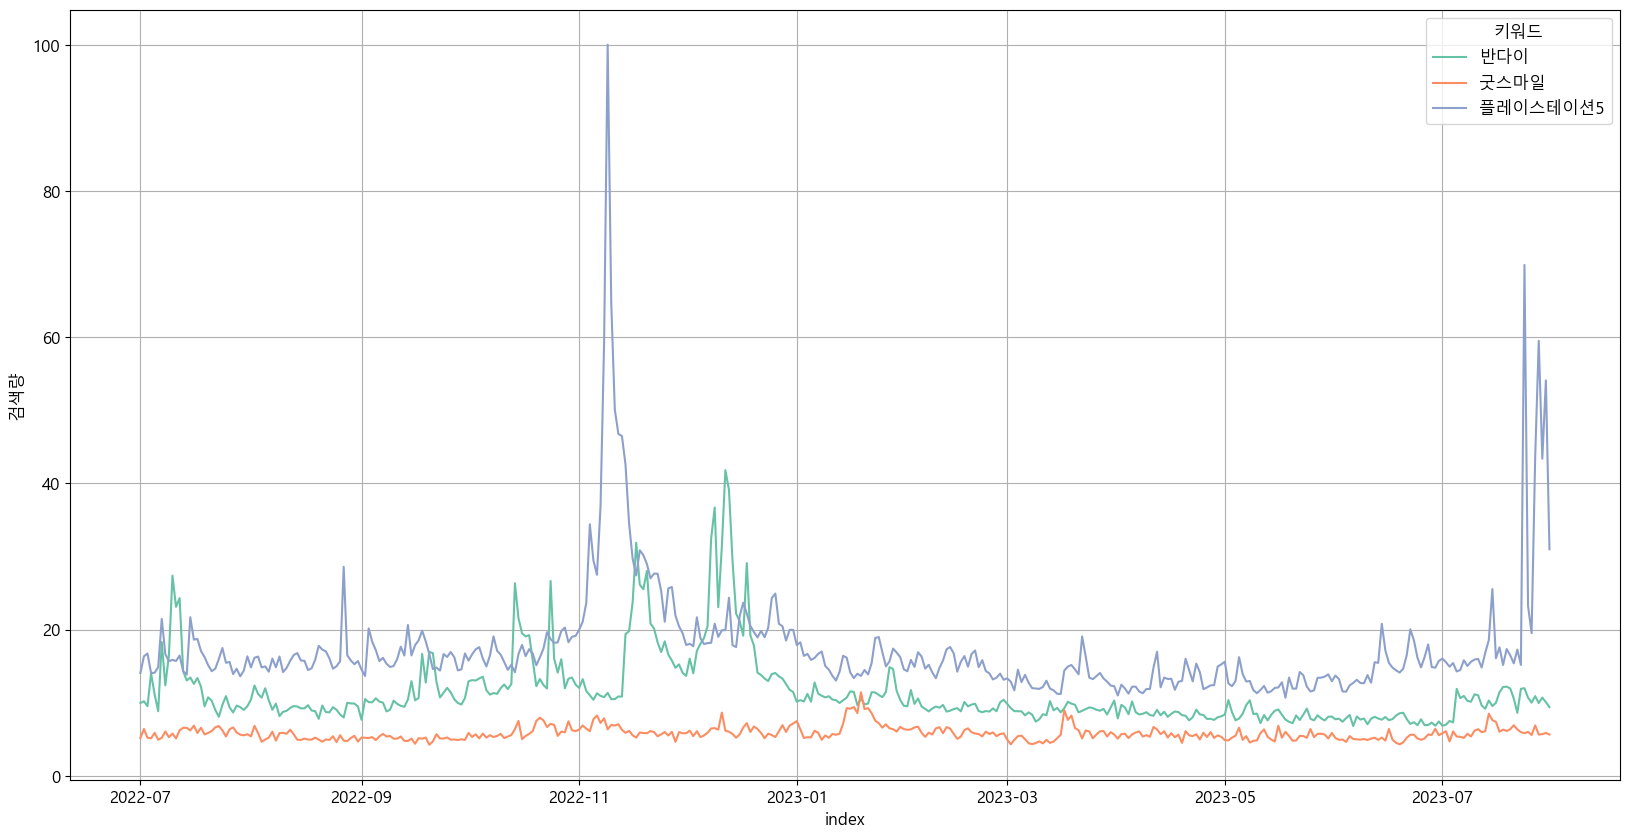

In [18]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

### helper에 구현된 기능을 활용하여 데이터 검정

반다이
결측치 수: 0


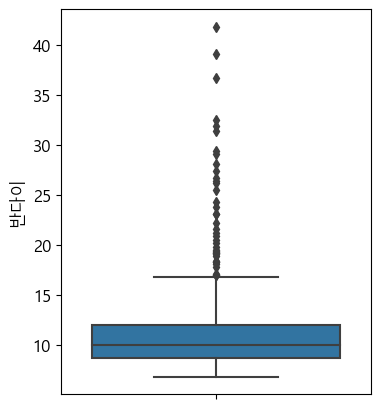

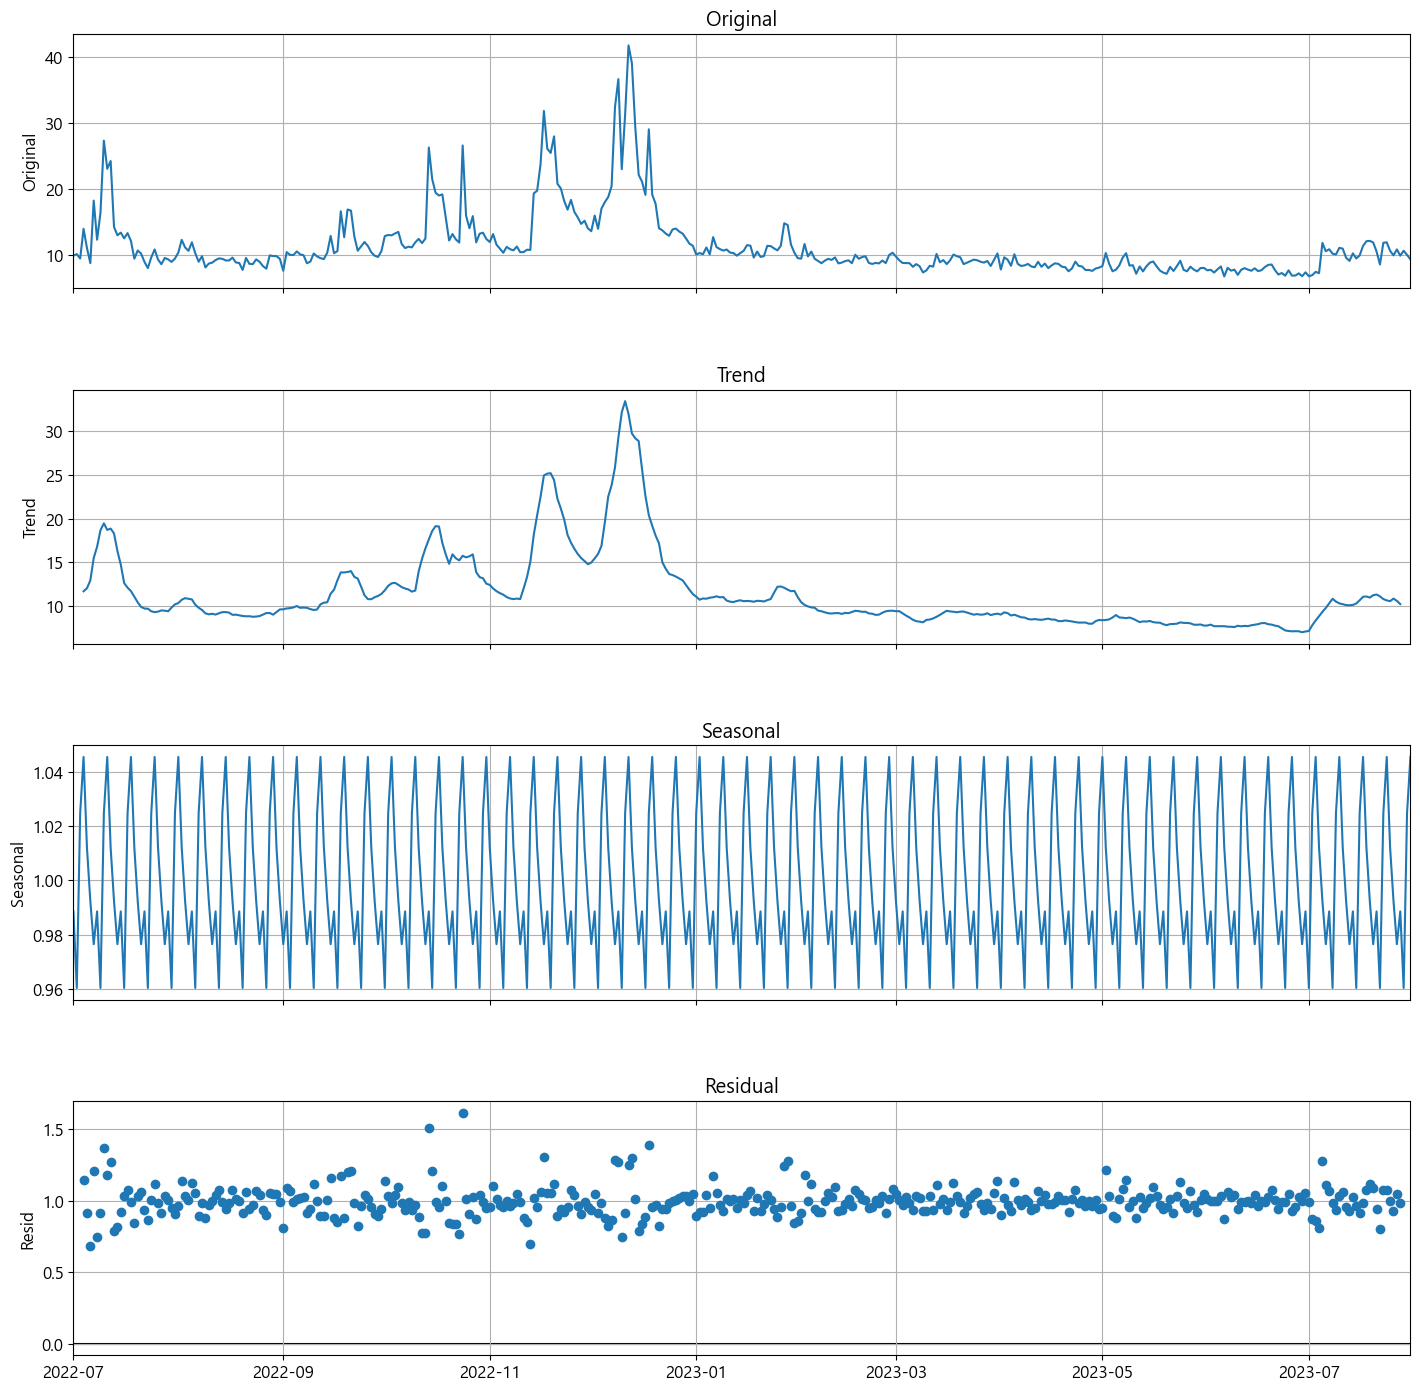

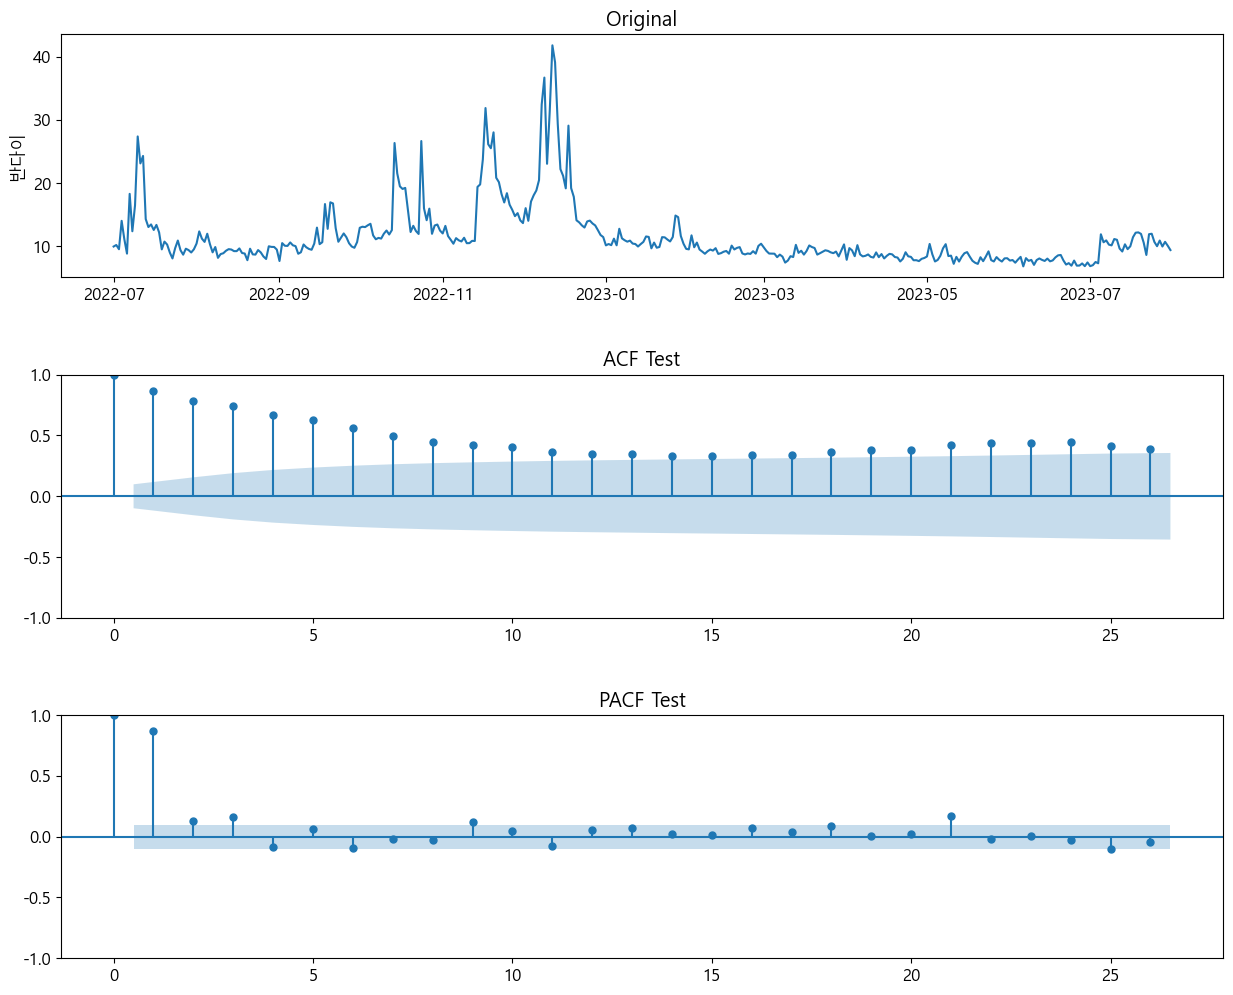

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -3.40531 |
| 유의수준(p-value)                  | 0.0107791 |
| 최적차수(num of lags)              |         8 |
| 관측치 개수(num of observations)   |       387 |
| 기각값(Critical Values) 1%         |  -3.44736 |
| 기각값(Critical Values) 5%         |  -2.86904 |
| 기각값(Critical Values) 10%        |  -2.57076 |
| 데이터 정상성 여부(0=Flase,1=True) |         1 |
+------------------------------------+-----------+
굿스마일
결측치 수: 0


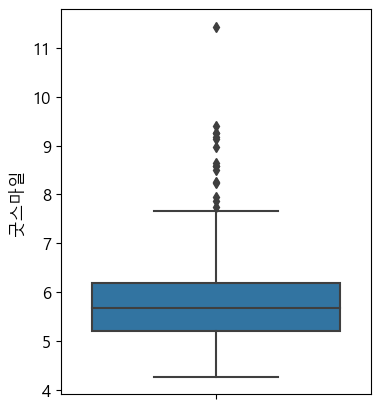

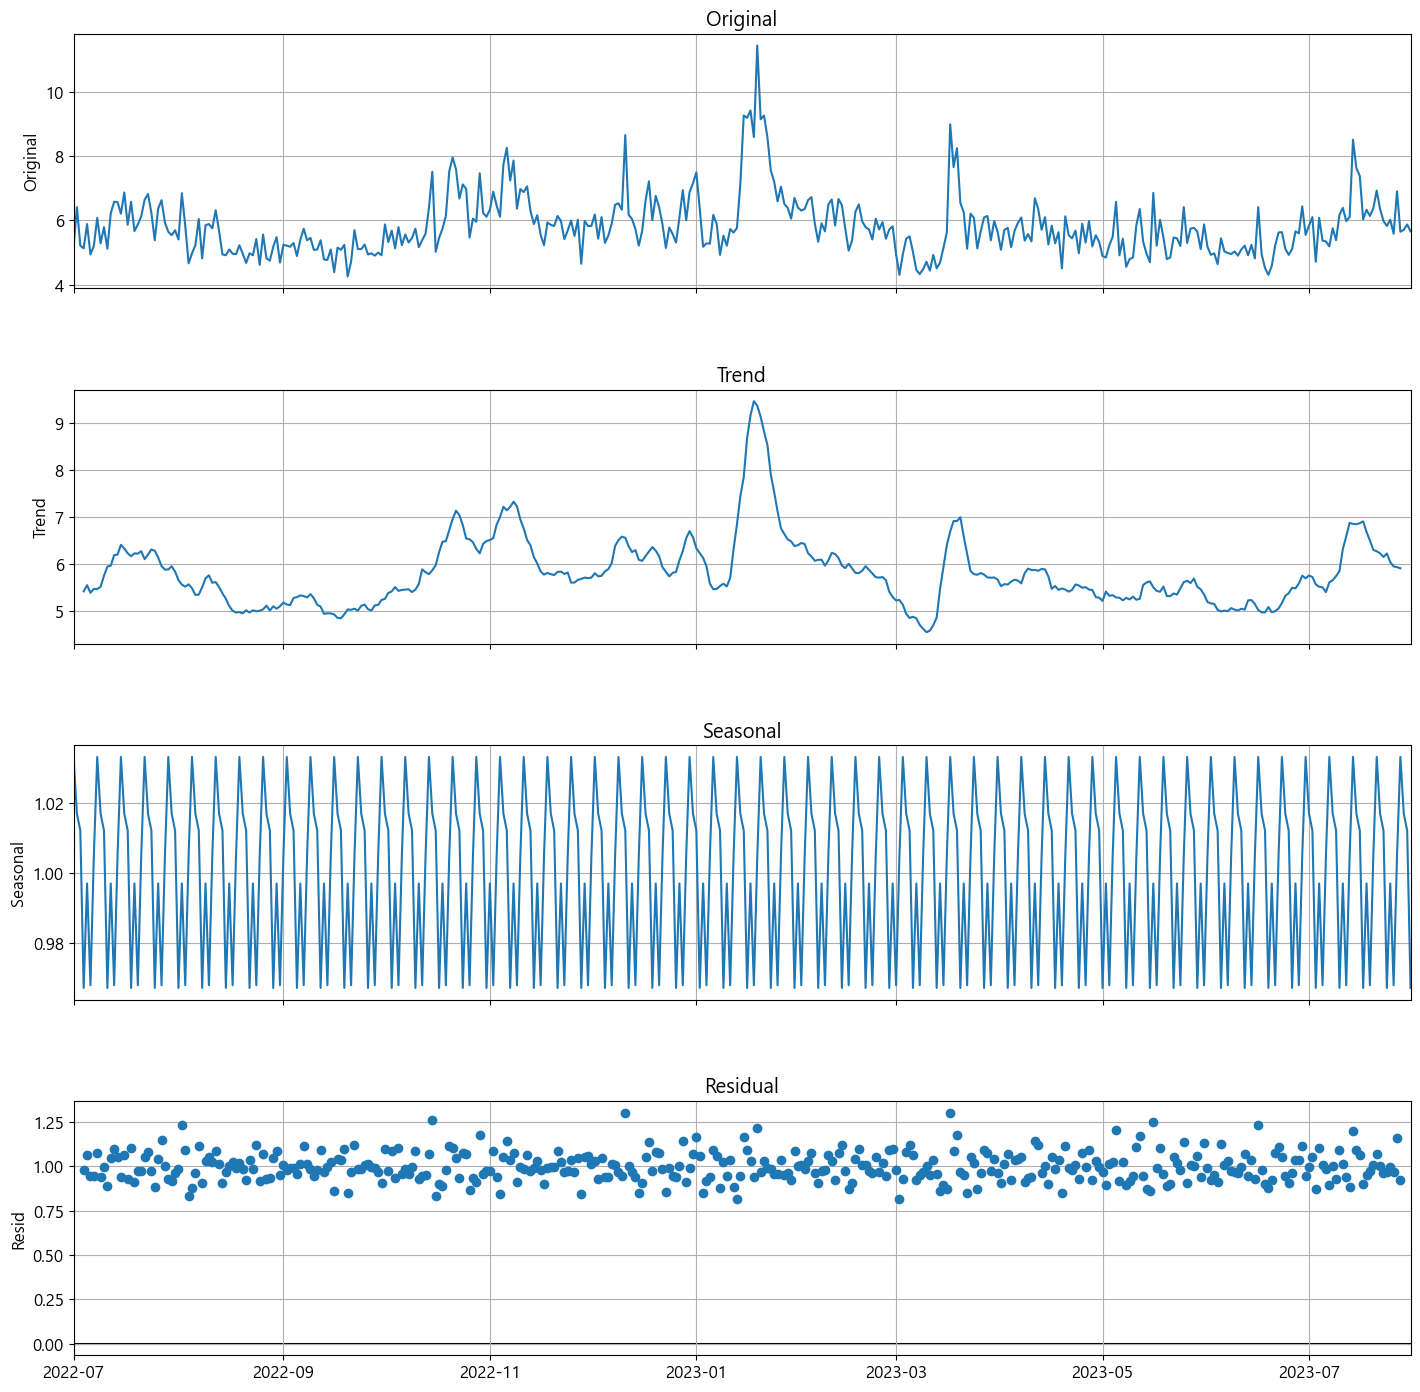

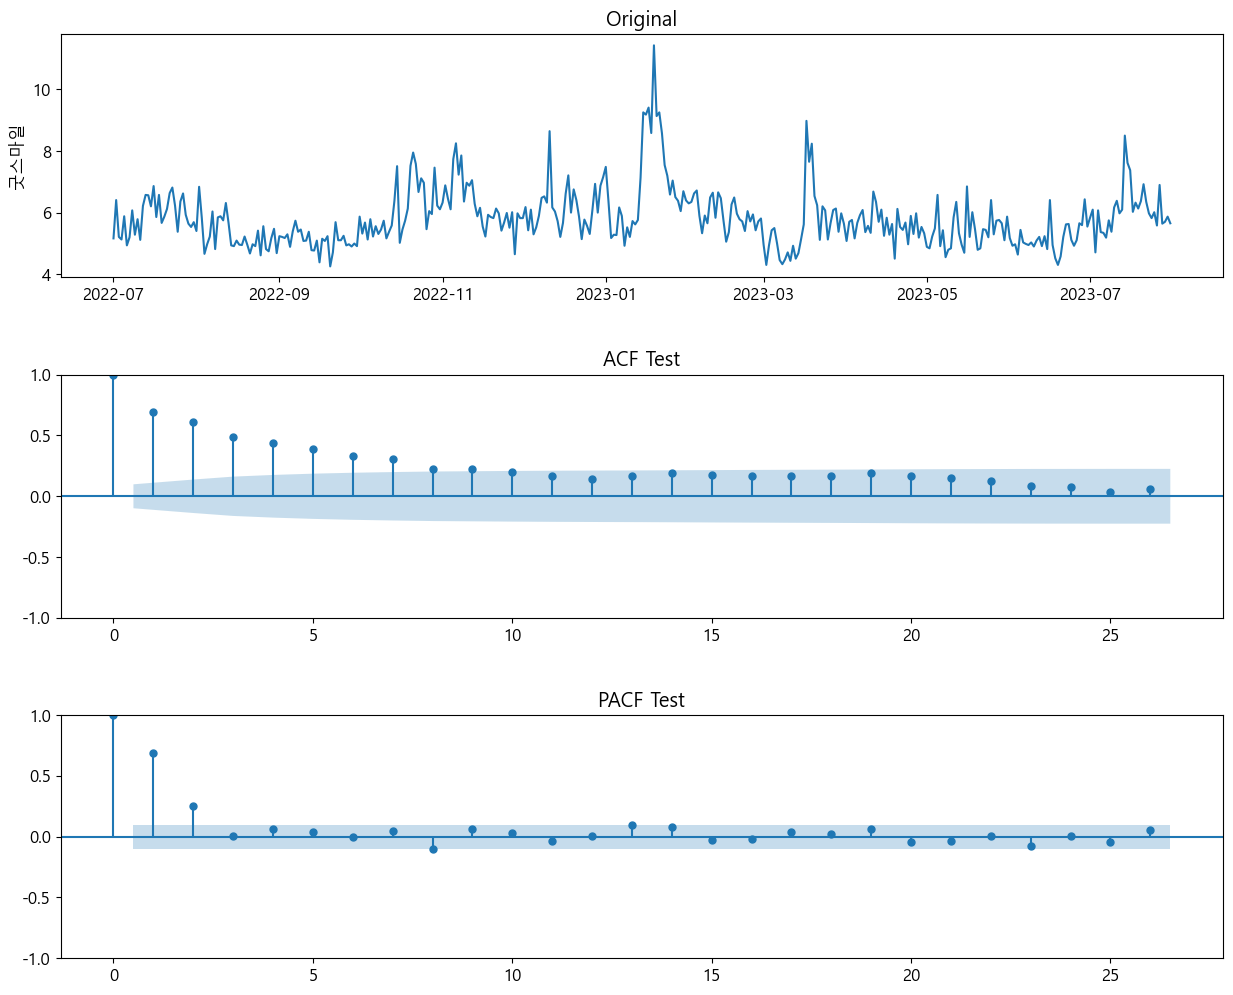

=========== 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -5.98803 |
| 유의수준(p-value)                  | 1.7729e-07 |
| 최적차수(num of lags)              |          1 |
| 관측치 개수(num of observations)   |        394 |
| 기각값(Critical Values) 1%         |   -3.44706 |
| 기각값(Critical Values) 5%         |    -2.8689 |
| 기각값(Critical Values) 10%        |   -2.57069 |
| 데이터 정상성 여부(0=Flase,1=True) |          1 |
+------------------------------------+------------+
플레이스테이션5
결측치 수: 0


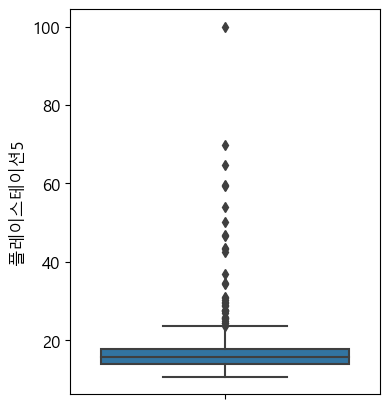

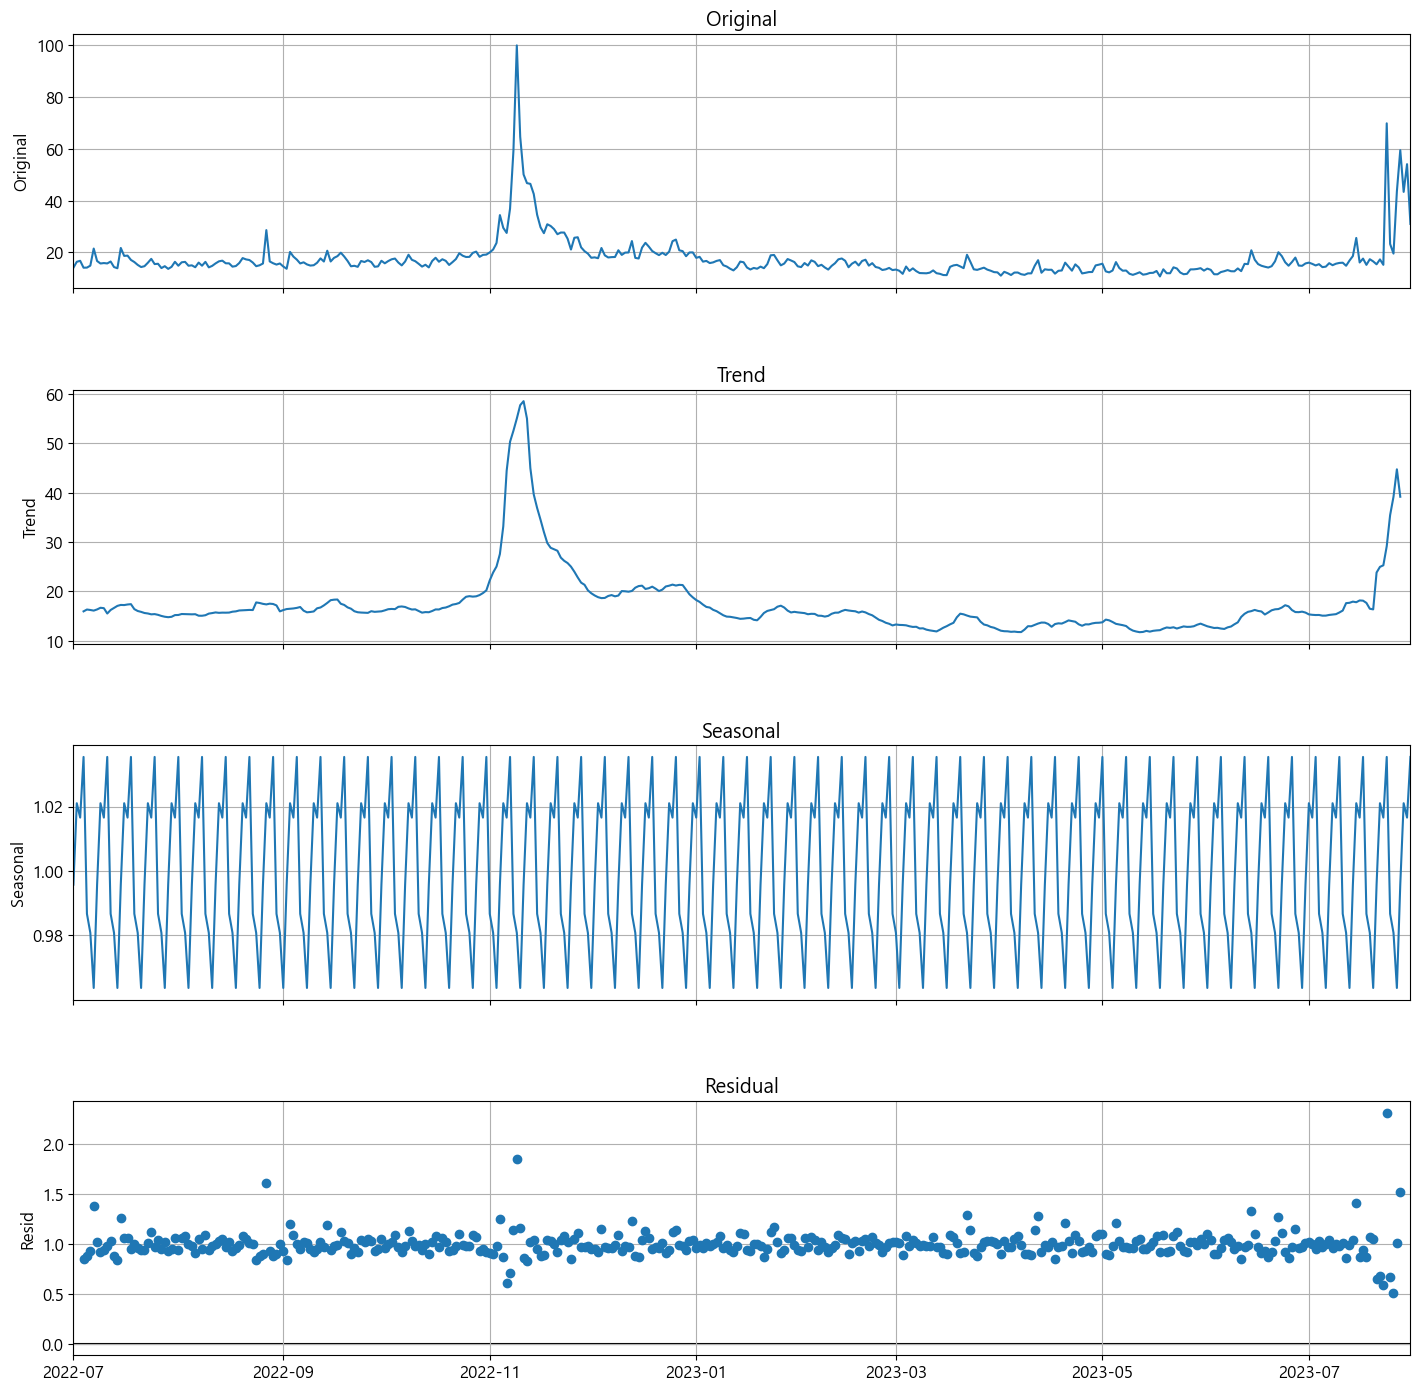

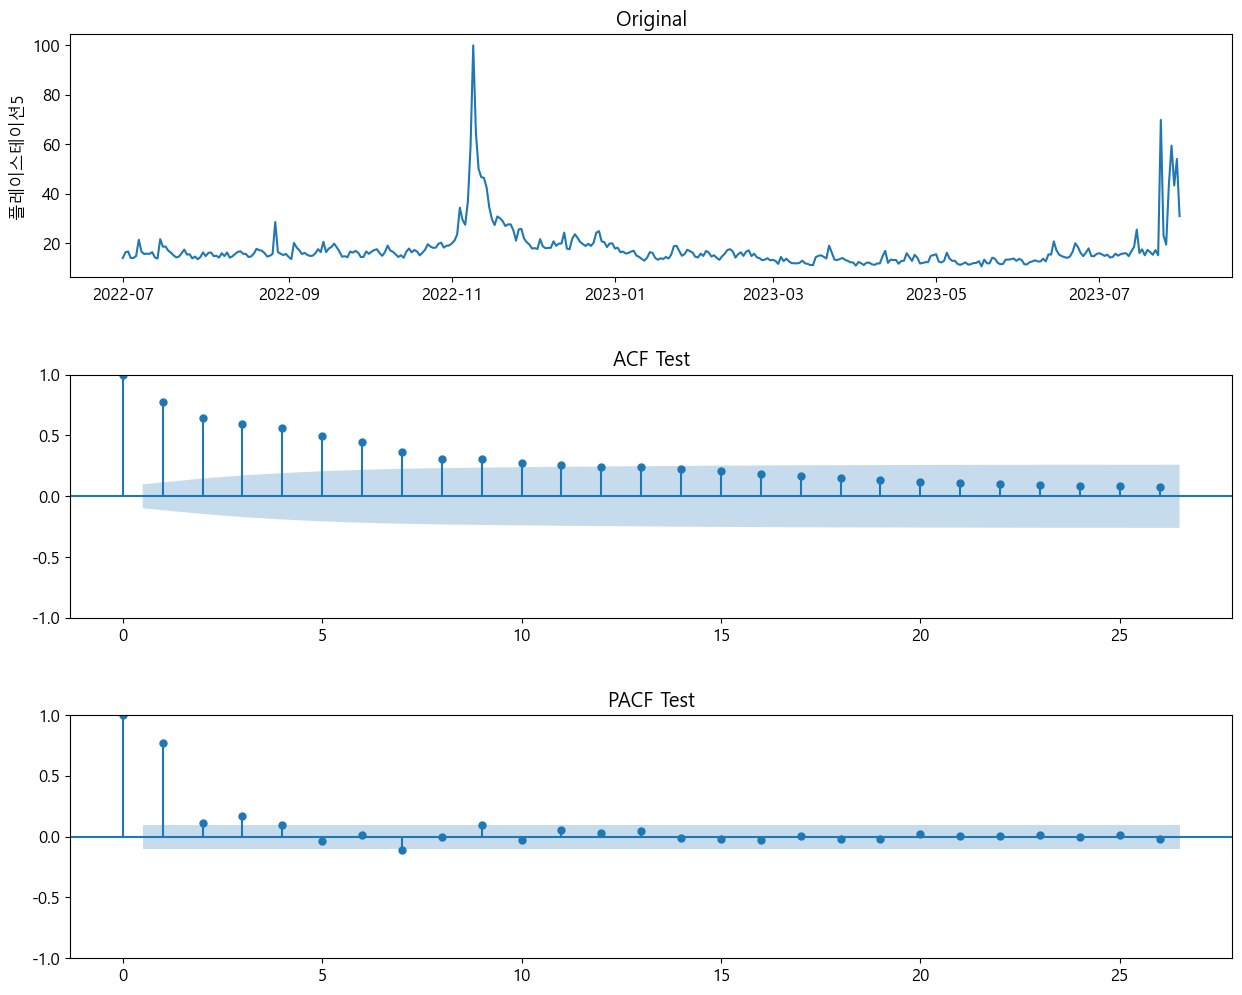

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.99271 |
| 유의수준(p-value)                  | 0.0355805 |
| 최적차수(num of lags)              |         9 |
| 관측치 개수(num of observations)   |       386 |
| 기각값(Critical Values) 1%         |  -3.44741 |
| 기각값(Critical Values) 5%         |  -2.86906 |
| 기각값(Critical Values) 10%        |  -2.57077 |
| 데이터 정상성 여부(0=Flase,1=True) |         1 |
+------------------------------------+-----------+


In [19]:
for c in df2.columns:
    print("=========================================")
    print(c)
    print("=========================================")

    exp_time_data(df2, c, "m", max_diff=10)

### ARIMA 분석 수행

#### 분석 모델 구성

In [20]:
pdq = (
    ((1,0,0),(1,0,0,7)),    # 0번째
    ((1,1,0),(1,1,0,7)),    # 1번째
    ((1,1,0),(1,1,0,7))     # 2번째
)

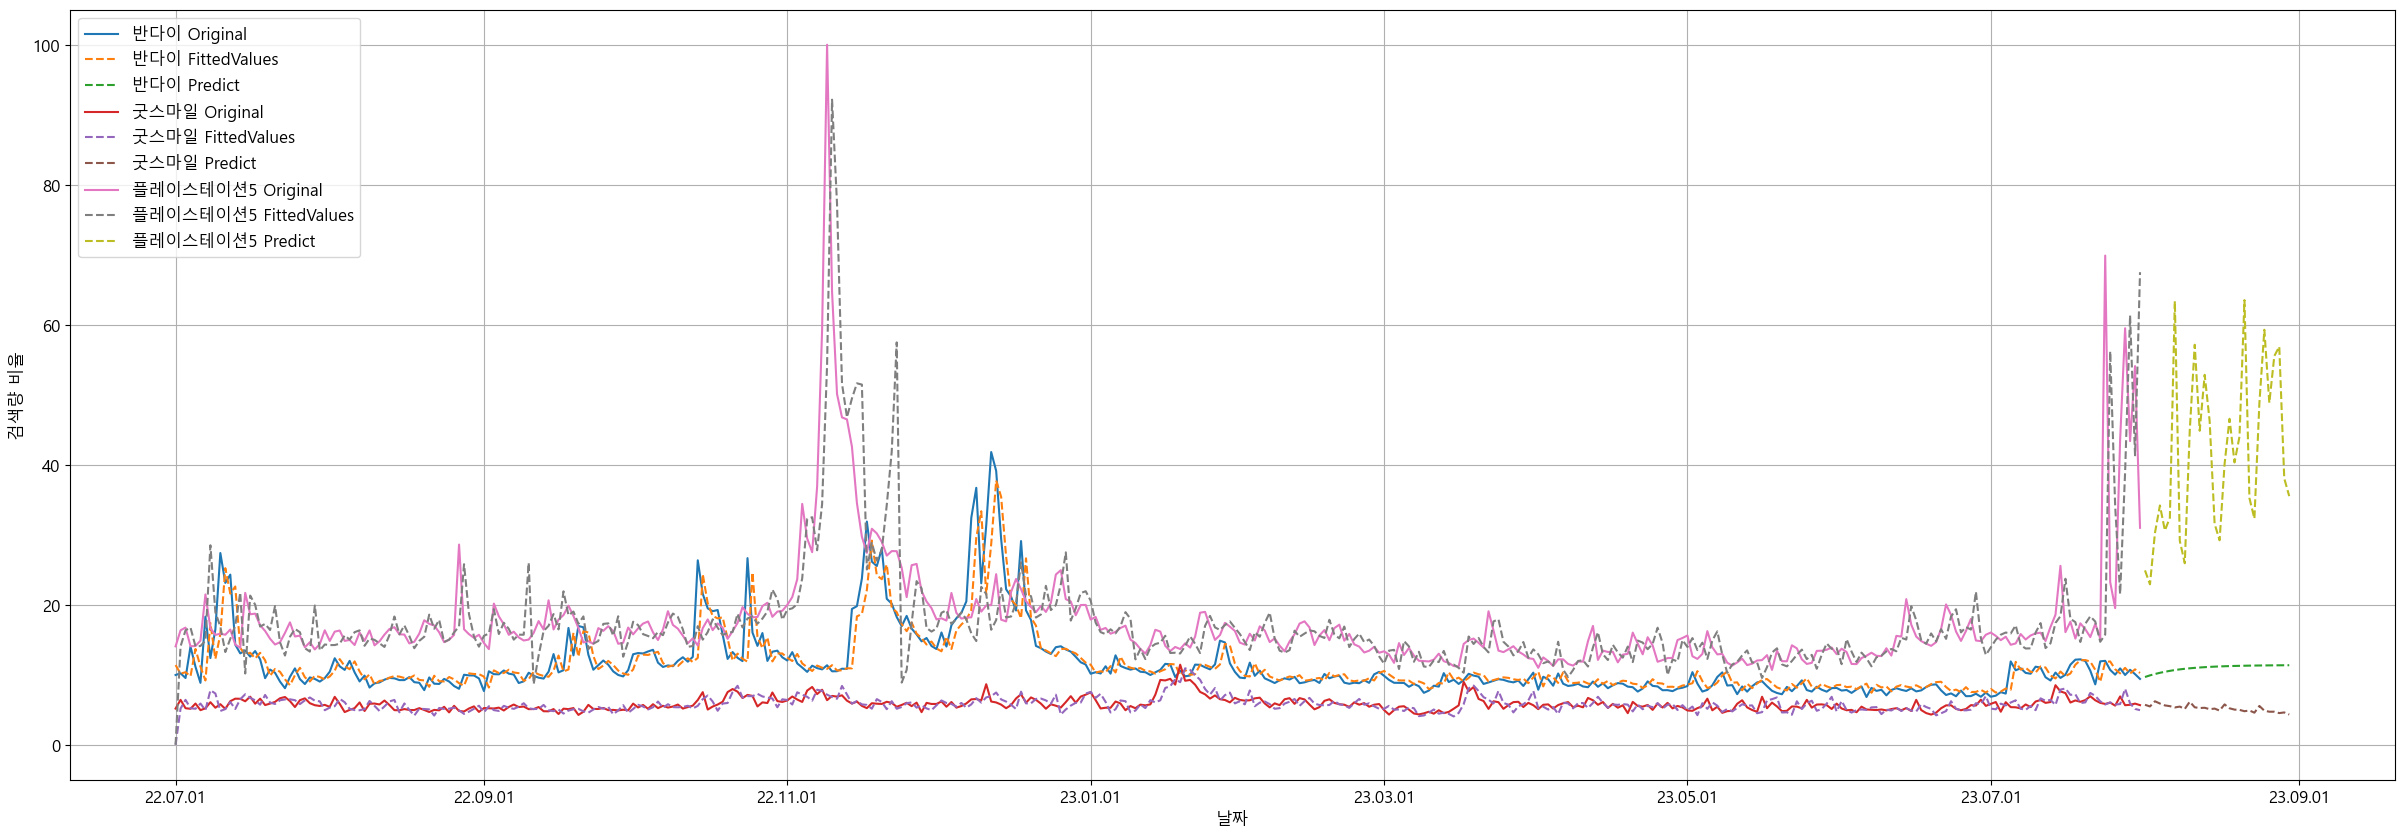

In [21]:
plt.figure(figsize=(30,10))

for i, c in enumerate(df2.columns):
    # 모델 구성
    model = ARIMA(df2[c], order=pdq[i][0], seasonal_order=pdq[i][1])
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)
    
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()